# Visualise sequence embeddings 

Visualise sequences embedded with Protvec models using PCA and tSNE

In [1]:
#imports 
import pandas as pd 
import numpy as np 
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans 
from matplotlib import pyplot as plt
import seaborn as sns
from collections import Counter

In [2]:
#import the sequences embedded with the bacillus carbohydrate metabolism trained model
embedding_bacil = pd.read_csv('bacillus_filtered_embedded.csv', sep = '\t')
embedding_s_bacil = embedding_bacil.dropna()
seqs_keys_bacil = embedding_bacil['Unnamed: 0']
seqs_s_keys_bacil = embedding_s_bacil['Unnamed: 0']

#read in the sequences embedded with swissprot 
embedding_swissprot_bacil = pd.read_csv('bacillus_filtered_embedded_swissprot.csv', sep = '\t')
embedding_swissprot_s_bacil= embedding_swissprot_bacil.dropna()
seqs_swiss_keys_bacil = embedding_swissprot_s_bacil['Unnamed: 0']

#import the sequences embedded with the bacteriodes carbohydrate metabolism trained model
embedding_bacter = pd.read_csv('bacteroides_filtered_embedded.csv', sep = '\t')
embedding_s_bacter = embedding_bacter.dropna()
seqs_keys_bacter = embedding_bacter['Unnamed: 0']
seqs_s_keys_bacter = embedding_s_bacter['Unnamed: 0']

#read in the bacteroides sequences embedded with swissprot 
embedding_swissprot_bacter = pd.read_csv('bacteroides_filtered_embedded_swissprot.csv', sep = '\t')
embedding_swissprot_s_bacter = embedding_swissprot_bacter.dropna()
seqs_swiss_keys_bacter = embedding_swissprot_s_bacter['Unnamed: 0']

In [3]:
#get the subsystems labels for bacillus 
sub_sys_bacil = pd.read_csv('bacillus.ids.tsv', sep = '\t', header = None)
sub_sys_bacil.columns =  ['fig_ID', 'species', 'superclass', 'class', 'subclass', 'subsystem', 'product role_name']

#get the file which takes the md5 hashes to the fig IDs 
md5_fig_bacil = pd.read_csv('bacillus.md5.ids', sep = '\t', header = None)
md5_fig_bacil.columns = ['md5', 'fig_ID']

#get the subsystems labels for bacteroides
sub_sys_bacter = pd.read_csv('bacteroides.ids.tsv', sep = '\t', header = None)
sub_sys_bacter.columns =  ['fig_ID', 'species', 'superclass', 'class', 'subclass', 'subsystem', 'product role_name']

#get the file which takes the md5 hashes to the fig IDs 
md5_fig_bacter = pd.read_csv('bacteroides.md5.ids', sep = '\t', header = None)
md5_fig_bacter.columns = ['md5', 'fig_ID']

#assemble as a dictionary which takes a seqence key to the ontological represenation 
seqs_keys_figID_bacil = pd.concat([md5_fig_bacil[md5_fig_bacil['md5'] == key] for key in seqs_s_keys_bacil])
seqs_keys_figID_swiss_bacil = pd.concat([md5_fig_bacil[md5_fig_bacil['md5'] == key] for key in seqs_swiss_keys_bacil])

seqs_keys_figID_bacter = pd.concat([md5_fig_bacter[md5_fig_bacter['md5'] == key] for key in seqs_s_keys_bacter])
seqs_keys_figID_swiss_bacter = pd.concat([md5_fig_bacter[md5_fig_bacter['md5'] == key] for key in seqs_swiss_keys_bacter])

In [4]:
#make dictionaries for subclass/superclass but this time include the entry 'dual'
fig2subclass_bacil = sub_sys_bacil[['fig_ID', 'subclass']].drop_duplicates()
fig2subsystem_bacil = sub_sys_bacil[['fig_ID', 'subsystem']].drop_duplicates()

#change fig_IDs which have more than one subclass to 'dual'
duplicate_subclasses_bacil = pd.DataFrame(fig2subclass_bacil['fig_ID'].value_counts())
duplicate_subclasses_bacil = duplicate_subclasses_bacil[duplicate_subclasses_bacil['fig_ID'] > 1].index.values
duplicate_removed_subclasses_bacil = fig2subclass_bacil[~fig2subclass_bacil['fig_ID'].isin(duplicate_subclasses_bacil)]

dual_vec = ['dual' for i in range(0,len(duplicate_subclasses_bacil))]
dual_subclasses_bacil = pd.DataFrame({'fig_ID': duplicate_subclasses_bacil, 'subclass': dual_vec})
fig2subclass_bacil = pd.concat([duplicate_removed_subclasses_bacil, dual_subclasses_bacil], axis = 0)

#change fig_IDs which have more than one subsystem to 'dual'
duplicate_subsystems_bacil = pd.DataFrame(fig2subsystem_bacil['fig_ID'].value_counts())
duplicate_subsystems_bacil = duplicate_subsystems_bacil[duplicate_subsystems_bacil['fig_ID'] > 1].index.values
duplicate_removed_subsystems_bacil = fig2subsystem_bacil[~fig2subsystem_bacil['fig_ID'].isin(duplicate_subsystems_bacil)]

dual_vec = ['dual' for i in range(0,len(duplicate_subsystems_bacil))]
dual_subsystems_bacil = pd.DataFrame({'fig_ID': duplicate_subsystems_bacil, 'subsystem': dual_vec})
fig2subsystem_bacil = pd.concat([duplicate_removed_subsystems_bacil, dual_subsystems_bacil], axis = 0)

#make these dataframes into dictionaries 
subclass_dict_bacil = dict(zip(fig2subclass_bacil['fig_ID'].values, fig2subclass_bacil['subclass'].values))
subsystem_dict_bacil = dict(zip(fig2subsystem_bacil['fig_ID'].values, fig2subsystem_bacil['subsystem'].values))

#add columns to dataframes for the subsystem and subclasses 
seqs_keys_figID_bacil['Subsystem'] = [subsystem_dict_bacil.get(fig_id) for fig_id in seqs_keys_figID_bacil['fig_ID']]
seqs_keys_figID_bacil['Subclass'] = [subclass_dict_bacil.get(fig_id) for fig_id in seqs_keys_figID_bacil['fig_ID']]

#collapse by _sysclass and subsystem 
seqs_subclass_bacil = seqs_keys_figID_bacil[['md5', 'Subclass']].drop_duplicates()
seqs_subsystem_bacil = seqs_keys_figID_bacil[['md5', 'Subsystem']].drop_duplicates()


In [15]:
#add columns to dataframes for the subsystem and subclasses 
seqs_keys_figID_swiss_bacil['Subsystem'] = [subsystem_dict_bacil.get(fig_id) for fig_id in seqs_keys_figID_swiss_bacil['fig_ID']]
seqs_keys_figID_swiss_bacil['Subclass'] = [subclass_dict_bacil.get(fig_id) for fig_id in seqs_keys_figID_swiss_bacil['fig_ID']]

#collapse by _sysclass and subsystem 
seqs_subclass_swiss_bacil = seqs_keys_figID_swiss_bacil[['md5', 'Subclass']].drop_duplicates()
seqs_subsystem_swiss_bacil = seqs_keys_figID_swiss_bacil[['md5', 'Subsystem']].drop_duplicates()

In [26]:
#add columns to dataframes for the subsystem and subclasses 
seqs_keys_figID_swiss_bacter['Subsystem'] = [subsystem_dict_bacter.get(fig_id) for fig_id in seqs_keys_figID_swiss_bacter['fig_ID']]
seqs_keys_figID_swiss_bacter['Subclass'] = [subclass_dict_bacter.get(fig_id) for fig_id in seqs_keys_figID_swiss_bacter['fig_ID']]

#collapse by _sysclass and subsystem 
seqs_subclass_swiss_bacter = seqs_keys_figID_swiss_bacter[['md5', 'Subclass']].drop_duplicates()
seqs_subsystem_swiss_bacter = seqs_keys_figID_swiss_bacter[['md5', 'Subsystem']].drop_duplicates()

In [5]:
#make dictionaries for subclass/superclass but this time include the entry 'dual'
fig2subclass_bacil = sub_sys_bacil[['fig_ID', 'subclass']].drop_duplicates()
fig2subsystem_bacil = sub_sys_bacil[['fig_ID', 'subsystem']].drop_duplicates()

#change fig_IDs which have more than one subclass to 'dual'
duplicate_subclasses_bacil = pd.DataFrame(fig2subclass_bacil['fig_ID'].value_counts())
duplicate_subclasses_bacil = duplicate_subclasses_bacil[duplicate_subclasses_bacil['fig_ID'] > 1].index.values
duplicate_removed_subclasses_bacil = fig2subclass_bacil[~fig2subclass_bacil['fig_ID'].isin(duplicate_subclasses_bacil)]

dual_vec = ['dual' for i in range(0,len(duplicate_subclasses_bacil))]
dual_subclasses_bacil = pd.DataFrame({'fig_ID': duplicate_subclasses_bacil, 'subclass': dual_vec})
fig2subclass_bacil = pd.concat([duplicate_removed_subclasses_bacil, dual_subclasses_bacil], axis = 0)

#change fig_IDs which have more than one subsystem to 'dual'
duplicate_subsystems_bacil = pd.DataFrame(fig2subsystem_bacil['fig_ID'].value_counts())
duplicate_subsystems_bacil = duplicate_subsystems_bacil[duplicate_subsystems_bacil['fig_ID'] > 1].index.values
duplicate_removed_subsystems_bacil = fig2subsystem_bacil[~fig2subsystem_bacil['fig_ID'].isin(duplicate_subsystems_bacil)]

dual_vec = ['dual' for i in range(0,len(duplicate_subsystems_bacil))]
dual_subsystems_bacil = pd.DataFrame({'fig_ID': duplicate_subsystems_bacil, 'subsystem': dual_vec})
fig2subsystem_bacil = pd.concat([duplicate_removed_subsystems_bacil, dual_subsystems_bacil], axis = 0)

#make these dataframes into dictionaries 
subclass_dict_bacil = dict(zip(fig2subclass_bacil['fig_ID'].values, fig2subclass_bacil['subclass'].values))
subsystem_dict_bacil = dict(zip(fig2subsystem_bacil['fig_ID'].values, fig2subsystem_bacil['subsystem'].values))

#add columns to dataframes for the subsystem and subclasses 
seqs_keys_figID_bacil['Subsystem'] = [subsystem_dict_bacil.get(fig_id) for fig_id in seqs_keys_figID_bacil['fig_ID']]
seqs_keys_figID_bacil['Subclass'] = [subclass_dict_bacil.get(fig_id) for fig_id in seqs_keys_figID_bacil['fig_ID']]

#collapse by subclass and subsystem 
seqs_subclass_bacil = seqs_keys_figID_bacil[['md5', 'Subclass']].drop_duplicates()
seqs_subsystem_bacil = seqs_keys_figID_bacil[['md5', 'Subsystem']].drop_duplicates()

In [6]:
#make dictionaries for subclass/superclass but this time include the entry 'dual'
fig2subclass_bacter = sub_sys_bacter[['fig_ID', 'subclass']].drop_duplicates()
fig2subsystem_bacter = sub_sys_bacter[['fig_ID', 'subsystem']].drop_duplicates()

#change fig_IDs which have more than one subclass to 'dual'
duplicate_subclasses_bacter = pd.DataFrame(fig2subclass_bacter['fig_ID'].value_counts())
duplicate_subclasses_bacter = duplicate_subclasses_bacter[duplicate_subclasses_bacter['fig_ID'] > 1].index.values
duplicate_removed_subclasses_bacter = fig2subclass_bacter[~fig2subclass_bacter['fig_ID'].isin(duplicate_subclasses_bacter)]

dual_vec = ['dual' for i in range(0,len(duplicate_subclasses_bacter))]
dual_subclasses_bacter = pd.DataFrame({'fig_ID': duplicate_subclasses_bacter, 'subclass': dual_vec})
fig2subclass_bacter = pd.concat([duplicate_removed_subclasses_bacter, dual_subclasses_bacter], axis = 0)

#change fig_IDs which have more than one subsystem to 'dual'
duplicate_subsystems_bacter = pd.DataFrame(fig2subsystem_bacter['fig_ID'].value_counts())
duplicate_subsystems_bacter = duplicate_subsystems_bacter[duplicate_subsystems_bacter['fig_ID'] > 1].index.values
duplicate_removed_subsystems_bacter = fig2subsystem_bacter[~fig2subsystem_bacter['fig_ID'].isin(duplicate_subsystems_bacter)]

dual_vec = ['dual' for i in range(0,len(duplicate_subsystems_bacter))]
dual_subsystems_bacter = pd.DataFrame({'fig_ID': duplicate_subsystems_bacter, 'subsystem': dual_vec})
fig2subsystem_bacter = pd.concat([duplicate_removed_subsystems_bacter, dual_subsystems_bacter], axis = 0)

#make these dataframes into dictionaries 
subclass_dict_bacter = dict(zip(fig2subclass_bacter['fig_ID'].values, fig2subclass_bacter['subclass'].values))
subsystem_dict_bacter = dict(zip(fig2subsystem_bacter['fig_ID'].values, fig2subsystem_bacter['subsystem'].values))

#add columns to dataframes for the subsystem and subclasses 
seqs_keys_figID_bacter['Subsystem'] = [subsystem_dict_bacter.get(fig_id) for fig_id in seqs_keys_figID_bacter['fig_ID']]
seqs_keys_figID_bacter['Subclass'] = [subclass_dict_bacter.get(fig_id) for fig_id in seqs_keys_figID_bacter['fig_ID']]

#collapse by subclass and subsystem 
seqs_subclass_bacter = seqs_keys_figID_bacter[['md5', 'Subclass']].drop_duplicates()
seqs_subsystem_bacter = seqs_keys_figID_bacter[['md5', 'Subsystem']].drop_duplicates()

In [7]:
seqs_subsystem_count = Counter(seqs_subsystem_bacil['md5'].values)
count_df = pd.DataFrame.from_dict(seqs_subsystem_count, orient='index').reset_index()
duplicates = count_df[count_df[0]>1] #this gives the 2 sequences with duplicates
duplicates_md5 = duplicates['index'].values
duplicates_df = seqs_subsystem_bacil[seqs_subsystem_bacil['md5'].isin(duplicates_md5)]
duplicates_idx = duplicates_df[duplicates_df['Subsystem'] != 'dual'].index.values
seqs_subsystem_bacil= seqs_subsystem_bacil.drop(duplicates_idx)

seqs_subsystem_count = Counter(seqs_subsystem_bacter['md5'].values)
count_df = pd.DataFrame.from_dict(seqs_subsystem_count, orient='index').reset_index()
duplicates = count_df[count_df[0]>1] #this gives the 2 sequences with duplicates
duplicates_md5 = duplicates['index'].values
duplicates_df = seqs_subsystem_bacter[seqs_subsystem_bacter['md5'].isin(duplicates_md5)]
duplicates_idx = duplicates_df[duplicates_df['Subsystem'] != 'dual'].index.values
seqs_subsystem_bacil= seqs_subsystem_bacter.drop(duplicates_idx)

#replace the dual labels 
seqs_subclass_bacil = seqs_subclass_bacil.replace('dual', 'CO2 fixation and C-1 compound metabolism')
seqs_subclass_bacter = seqs_subclass_bacter.replace('dual', 'CO2 fixation and C-1 compound metabolism')

#set the colourmap for the plots
cmap = ('#a6cee3', '#1f78b4', '#b2df8a', '#33a02c', '#fb9a99', '#e31a1c', '#fdbf6f', '#ff7f00', '#cab2d6', '#6a3d9a' ) #colour map for the plots 

# PCA  and TSNE of the embeddings

### Bacillus sequences embedded with Bacillus model

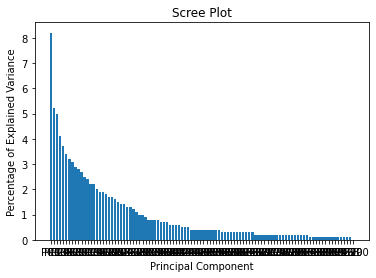

Can see that there is little difference in the eigenvalues - little variance explained


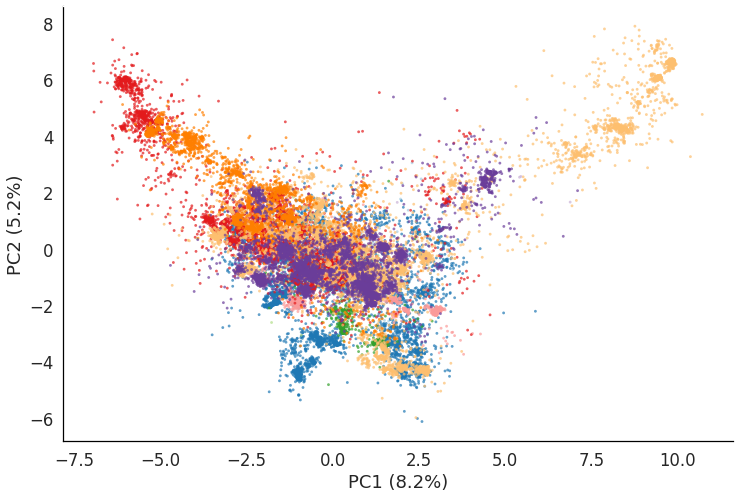

In [9]:
#do the PCA 
embedding_scaled = StandardScaler().fit_transform(embedding_s_bacil.drop(['Unnamed: 0'], axis = 1).values)

pca = PCA()
embedding_pca = pca.fit_transform(embedding_scaled)

#do the scree plot - see how the PCA went 
per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]
plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
plt.show()
print('Can see that there is little difference in the eigenvalues - little variance explained')

#plot the PCA 
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]
pca_df = pd.DataFrame(embedding_pca, columns=labels).set_index(seqs_s_keys_bacil)
pca_df['Subclass'] = seqs_subclass_bacil['Subclass'].values

#sort the pca df by the subclass labels - allows to keep colours consistent between models 
pca_df = pca_df.sort_values('Subclass')

#get the labels for the plot 
x_label = 'PC1 ('+str(np.round(per_var[0],2))+"%)"
y_label = 'PC2 ('+str(np.round(per_var[1],2))+"%)"

sns.set(font_scale = 1.5)
fig, ax = plt.subplots(1, 1, figsize = (12,8))
ax.set_facecolor('white')
plt.xlabel(x_label, fontsize = 18)
plt.ylabel(y_label, fontsize = 18)
sns.scatterplot(x = 'PC1', y = 'PC2', hue = 'Subclass',data = pca_df, legend = 'full', s = 8,linewidth=0, alpha = 0.7, palette = cmap)
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
plt.legend([],[], frameon=False)

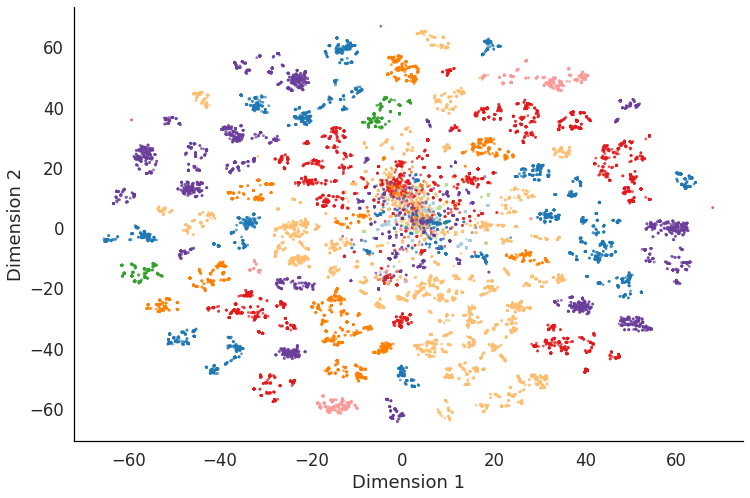

In [10]:
#do the tSNE
tsne = TSNE(perplexity = 50, learning_rate = 100)
embedding_tsne = tsne.fit_transform(embedding_scaled)

#plot it scatter plot 
tsne_df = pd.DataFrame(embedding_tsne, columns = ['Dimension 1', 'Dimension 2']).set_index(seqs_s_keys_bacil)

#colour by subclass 
tsne_df['Subclass'] = seqs_subclass_bacil['Subclass'].values

#sort so that the colouring is consistent 
tsne_df = tsne_df.sort_values('Subclass')

sns.set(font_scale = 1.5)
fig, ax = plt.subplots(1, 1, figsize = (12,8))
ax.set_facecolor('white')
plt.xlabel('Dimension 1', fontsize = 18)
plt.ylabel('Dimension 2', fontsize = 18)
sns.scatterplot(x = 'Dimension 1', y = 'Dimension 2', hue = 'Subclass',data = tsne_df, s = 8,linewidth=0, alpha = 0.7, palette = cmap)
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
plt.legend([],[], frameon=False)

### Bacillus sequences embedded with Swissprot model 

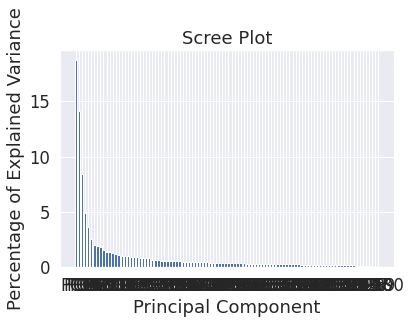

Can see that there is little difference in the eigenvalues - little variance explained


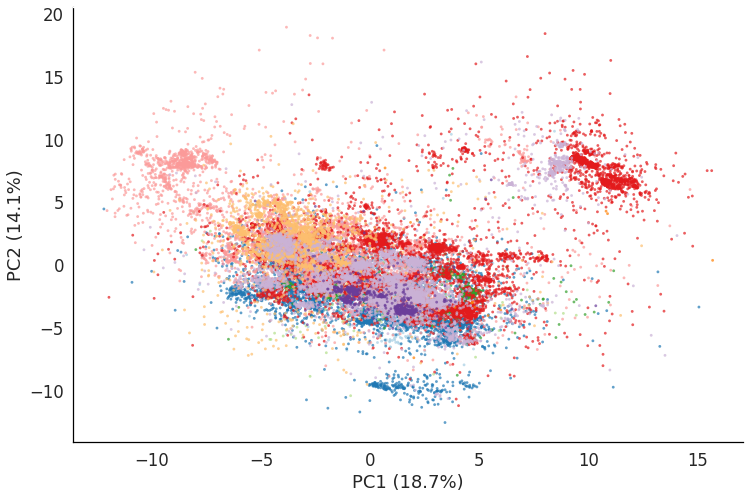

In [21]:
#do the PCA 
embedding_scaled = StandardScaler().fit_transform(embedding_swissprot_s_bacil.drop(['Unnamed: 0'], axis = 1).values)

pca = PCA()
embedding_pca = pca.fit_transform(embedding_scaled)

#do the scree plot - see how the PCA went 
per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]
plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
plt.show()
print('Can see that there is little difference in the eigenvalues - little variance explained')

#plot the PCA 
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]
pca_df = pd.DataFrame(embedding_pca, columns=labels).set_index(seqs_swiss_keys_bacil)
pca_df['Subclass'] = seqs_subclass_swiss_bacil['Subclass'].values

#sort the pca df by the subclass labels - allows to keep colours consistent between models 
pca_df = pca_df.sort_values('Subclass')

#get the labels for the plot 
x_label = 'PC1 ('+str(np.round(per_var[0],2))+"%)"
y_label = 'PC2 ('+str(np.round(per_var[1],2))+"%)"

sns.set(font_scale = 1.5)
fig, ax = plt.subplots(1, 1, figsize = (12,8))
ax.set_facecolor('white')
plt.xlabel(x_label, fontsize = 18)
plt.ylabel(y_label, fontsize = 18)
sns.scatterplot(x = 'PC1', y = 'PC2', hue = 'Subclass',data = pca_df, legend = 'full', s = 8,linewidth=0, alpha = 0.7, palette = cmap)
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
plt.legend([],[], frameon=False)

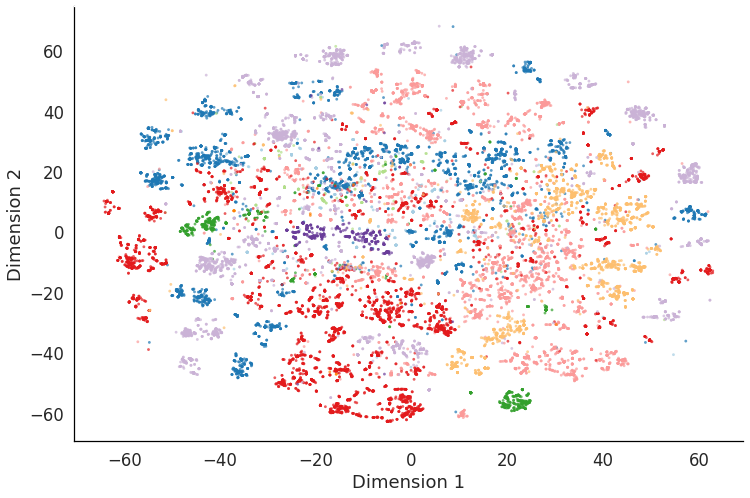

In [23]:
#do the tSNE
tsne = TSNE(perplexity = 50, learning_rate = 100)
embedding_tsne = tsne.fit_transform(embedding_scaled)

#plot it scatter plot 
tsne_df = pd.DataFrame(embedding_tsne, columns = ['Dimension 1', 'Dimension 2']).set_index(seqs_swiss_keys_bacil)
#colour by subclass 
tsne_df['Subclass'] = seqs_subclass_swiss_bacil['Subclass'].values

#sort so that the colouring is consistent 
tsne_df = tsne_df.sort_values('Subclass')

sns.set(font_scale = 1.5)
fig, ax = plt.subplots(1, 1, figsize = (12,8))
ax.set_facecolor('white')
plt.xlabel('Dimension 1', fontsize = 18)
plt.ylabel('Dimension 2', fontsize = 18)
sns.scatterplot(x = 'Dimension 1', y = 'Dimension 2', hue = 'Subclass',data = tsne_df, s = 8,linewidth=0, alpha = 0.7, palette = cmap)
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
plt.legend([],[], frameon=False)

### Bacteroides sequences embedded with the Bacteroides model 

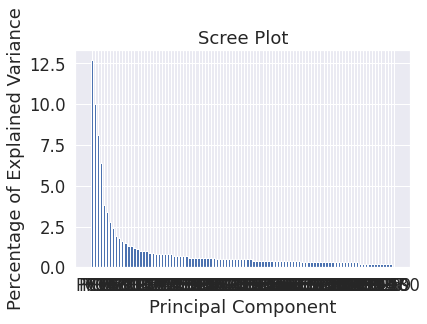

Can see that there is little difference in the eigenvalues - little variance explained


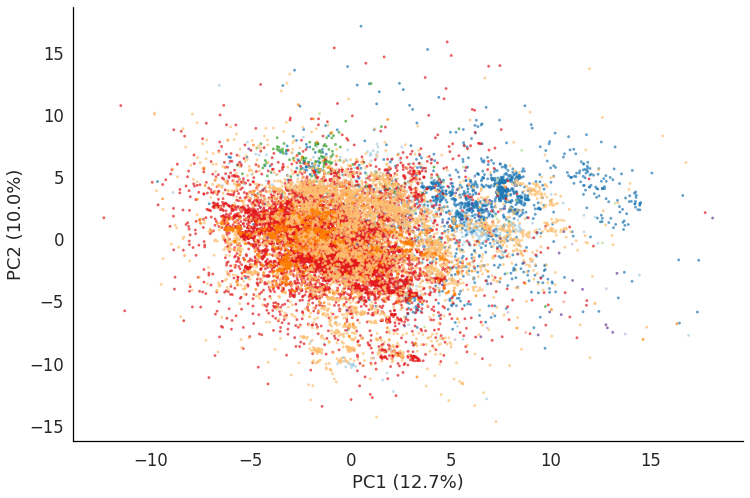

In [12]:
#do the PCA 
embedding_scaled = StandardScaler().fit_transform(embedding_s_bacter.drop(['Unnamed: 0'], axis = 1).values)

pca = PCA()
embedding_pca = pca.fit_transform(embedding_scaled)

#do the scree plot - see how the PCA went 
per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]
plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
plt.show()
print('Can see that there is little difference in the eigenvalues - little variance explained')

#plot the PCA 
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]
pca_df = pd.DataFrame(embedding_pca, columns=labels).set_index(seqs_s_keys_bacter)
pca_df['Subclass'] = seqs_subclass_bacter['Subclass'].values

#sort the pca df by the subclass labels - allows to keep colours consistent between models 
pca_df = pca_df.sort_values('Subclass')

#get the labels for the plot 
x_label = 'PC1 ('+str(np.round(per_var[0],2))+"%)"
y_label = 'PC2 ('+str(np.round(per_var[1],2))+"%)"

sns.set(font_scale = 1.5)
fig, ax = plt.subplots(1, 1, figsize = (12,8))
ax.set_facecolor('white')
plt.xlabel(x_label, fontsize = 18)
plt.ylabel(y_label, fontsize = 18)
sns.scatterplot(x = 'PC1', y = 'PC2', hue = 'Subclass',data = pca_df, legend = 'full', s = 8,linewidth=0, alpha = 0.7, palette = cmap)
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
plt.legend([],[], frameon=False)

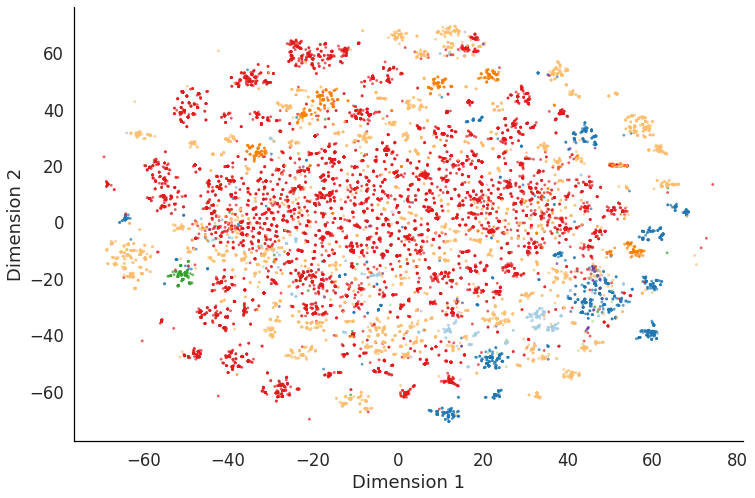

In [14]:
#do the tSNE
tsne = TSNE(perplexity = 50, learning_rate = 100)
embedding_tsne = tsne.fit_transform(embedding_scaled)

#plot it scatter plot 
tsne_df = pd.DataFrame(embedding_tsne, columns = ['Dimension 1', 'Dimension 2']).set_index(seqs_s_keys_bacter)

#colour by subclass 
tsne_df['Subclass'] = seqs_subclass_bacter['Subclass'].values

#sort so that the colouring is consistent 
tsne_df = tsne_df.sort_values('Subclass')

sns.set(font_scale = 1.5)
fig, ax = plt.subplots(1, 1, figsize = (12,8))
ax.set_facecolor('white')
plt.xlabel('Dimension 1', fontsize = 18)
plt.ylabel('Dimension 2', fontsize = 18)
sns.scatterplot(x = 'Dimension 1', y = 'Dimension 2', hue = 'Subclass',data = tsne_df, s = 8,linewidth=0, alpha = 0.7, palette = cmap)
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
plt.legend([],[], frameon=False)

### Bacteroides sequences embedded with Swissprot model 

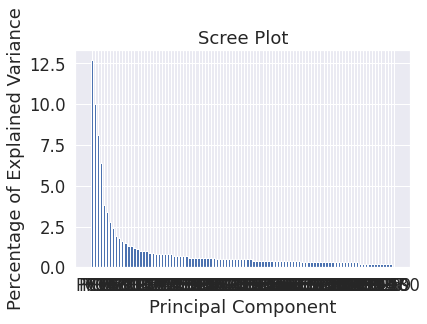

Can see that there is little difference in the eigenvalues - little variance explained


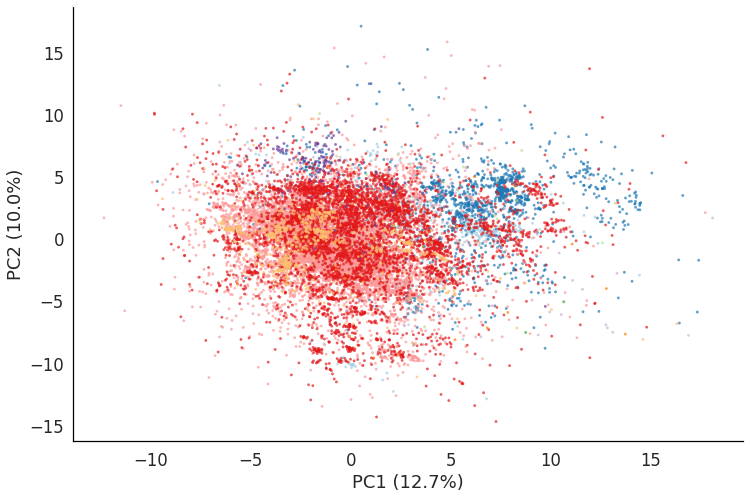

In [27]:
#do the PCA 
embedding_scaled = StandardScaler().fit_transform(embedding_swissprot_s_bacter.drop(['Unnamed: 0'], axis = 1).values)

pca = PCA()
embedding_pca = pca.fit_transform(embedding_scaled)

#do the scree plot - see how the PCA went 
per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]
plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
plt.show()
print('Can see that there is little difference in the eigenvalues - little variance explained')

#plot the PCA
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]
pca_df = pd.DataFrame(embedding_pca, columns=labels).set_index(seqs_swiss_keys_bacter)
pca_df['Subclass'] = seqs_subclass_swiss_bacter['Subclass'].values

#sort the pca df by the subclass labels - allows to keep colours consistent between models 
pca_df = pca_df.sort_values('Subclass')

#get the labels for the plot 
x_label = 'PC1 ('+str(np.round(per_var[0],2))+"%)"
y_label = 'PC2 ('+str(np.round(per_var[1],2))+"%)"

sns.set(font_scale = 1.5)
fig, ax = plt.subplots(1, 1, figsize = (12,8))
ax.set_facecolor('white')
plt.xlabel(x_label, fontsize = 18)
plt.ylabel(y_label, fontsize = 18)
sns.scatterplot(x = 'PC1', y = 'PC2', hue = 'Subclass',data = pca_df, legend = 'full', s = 8,linewidth=0, alpha = 0.7, palette = cmap)
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
plt.legend([],[], frameon=False)

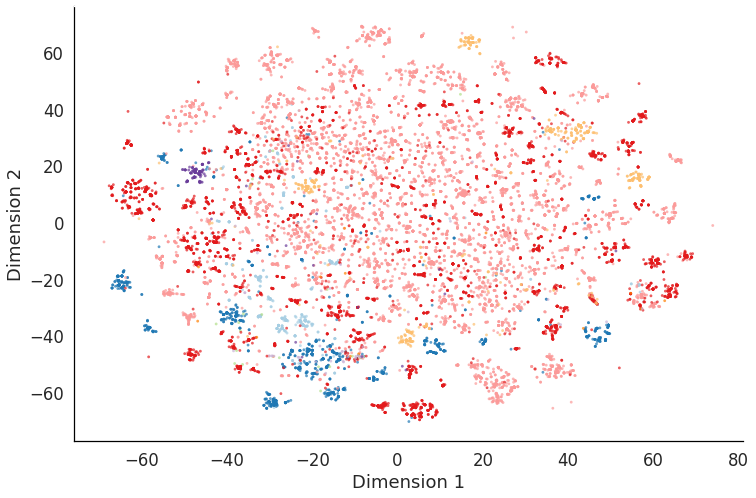

In [29]:
#do the tSNE
tsne = TSNE(perplexity = 50, learning_rate = 100)
embedding_tsne = tsne.fit_transform(embedding_scaled)

#plot it scatter plot 
tsne_df = pd.DataFrame(embedding_tsne, columns = ['Dimension 1', 'Dimension 2']).set_index(seqs_swiss_keys_bacter)

#colour by subclass 
tsne_df['Subclass'] = seqs_subclass_swiss_bacter['Subclass'].values

#sort so that the colouring is consistent 
tsne_df = tsne_df.sort_values('Subclass')

sns.set(font_scale = 1.5)
fig, ax = plt.subplots(1, 1, figsize = (12,8))
ax.set_facecolor('white')
plt.xlabel('Dimension 1', fontsize = 18)
plt.ylabel('Dimension 2', fontsize = 18)
sns.scatterplot(x = 'Dimension 1', y = 'Dimension 2', hue = 'Subclass',data = tsne_df, s = 8,linewidth=0, alpha = 0.7, palette = cmap)
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
plt.legend([],[], frameon=False)